# Imports

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Import Dataset

In [41]:
df = pd.read_csv('/kaggle/input/flight-and-weather-data/final_data.csv')


In [42]:
df.shape

(21319, 42)

In [43]:
df.iloc[0]

FlightID                                                                   0
flight_date                                                       2023-05-20
unique_carrier_id                                                         WN
flight_number                                                           1623
origin_airport                                                           ATL
destination_airport                                                      LGA
expected_departure_time                                             08:45:00
departure_delay                                                          111
expected_arrival_time                                               11:00:00
arrival_delay                                                             94
station_x                                                        USW00013874
name_x                     ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
date_x                                                            2023-05-20

In [44]:
df.columns

Index(['FlightID', 'flight_date', 'unique_carrier_id', 'flight_number',
       'origin_airport', 'destination_airport', 'expected_departure_time',
       'departure_delay', 'expected_arrival_time', 'arrival_delay',
       'station_x', 'name_x', 'date_x', 'awnd_x', 'prcp_x', 'snow_x', 'snwd_x',
       'tavg_x', 'wdf2_x', 'id_x', 'code_x', 'code_name_x', 'weather_name_x',
       'lev_x', 'lat_x', 'long_x', 'station_y', 'name_y', 'date_y', 'awnd_y',
       'prcp_y', 'snow_y', 'snwd_y', 'tavg_y', 'wdf2_y', 'id_y', 'code_y',
       'code_name_y', 'weather_name_y', 'lev_y', 'lat_y', 'long_y'],
      dtype='object')

## Convert to Datetime
## Generate Date-Based Columns (month, day, day_of_week, arr_time and dep_time to total minutes)
## Convert snow to boolean
## Set Feature Columns

In [45]:
df['flight_date'] = pd.to_datetime(df['flight_date'])

df['month'] = df['flight_date'].dt.month
df['day'] = df['flight_date'].dt.day
df['day_of_week'] = df['flight_date'].dt.dayofweek 

df['expected_departure_time'] = pd.to_datetime(df['expected_departure_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(df['expected_departure_time'], format='%H:%M:%S').dt.minute
df['expected_arrival_time'] = pd.to_datetime(df['expected_arrival_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(df['expected_arrival_time'], format='%H:%M:%S').dt.minute

df['snow_x'] = (df['snow_x'] > 0).astype(int)
df['snow_y'] = (df['snow_y'] > 0).astype(int)

features = ['month', 'day', 'day_of_week',
    'unique_carrier_id', 'flight_number', 'origin_airport', 'destination_airport',
    'expected_departure_time', 'expected_arrival_time',
    'awnd_x', 'prcp_x', 'snow_x','tavg_x', 'wdf2_x',
    'awnd_y','prcp_y', 'snow_y', 'tavg_y', 'wdf2_y']

# Label: we have 2
## Stage 1: label1
## Stage 2: label2

In [46]:
df['label1'] = (df['departure_delay'] >= 15).astype(int)
df = df.rename(columns={'departure_delay': 'label2'})

# Data Preprocessing and Null Value Exploration

In [47]:
df.isnull().sum()

FlightID                      0
flight_date                   0
unique_carrier_id             0
flight_number                 0
origin_airport                0
destination_airport           0
expected_departure_time       0
label2                        0
expected_arrival_time         0
arrival_delay                 0
station_x                     0
name_x                        0
date_x                        0
awnd_x                        0
prcp_x                        0
snow_x                        0
snwd_x                     1733
tavg_x                     1341
wdf2_x                        0
id_x                          0
code_x                        0
code_name_x                   0
weather_name_x                0
lev_x                         0
lat_x                         0
long_x                        0
station_y                     0
name_y                        0
date_y                        0
awnd_y                        0
prcp_y                        0
snow_y  

# Null Value Handling
### Null values mean different things for different columns
### snow and snwd = 0 when NA
### tavg will be fixed using imputation by airport

In [48]:
df['snow_x'].fillna(0, inplace=True)
df['snwd_x'].fillna(0, inplace=True)
df['snow_y'].fillna(0, inplace=True)
df['snwd_y'].fillna(0, inplace=True)

In [49]:
df['tavg_x'] = df['tavg_x'].fillna(df['tavg_x'].mean())
df['tavg_y'] = df['tavg_y'].fillna(df['tavg_y'].mean())

# Exploratory Data Analysis

Let's first look at how our data is spread out so we can properly bucketize our outputs.

Let's plot a graph that shows the delay in minutes with regard to each day of the week.

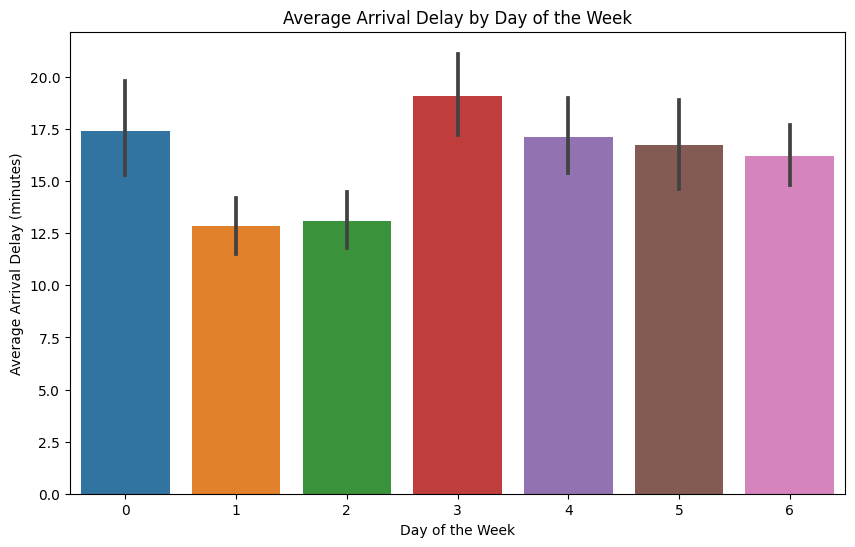

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='arrival_delay', data=df, estimator=lambda x: sum(x) / len(x))
plt.title('Average Arrival Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Arrival Delay (minutes)')
plt.show()

### Lets also plot the general label distribution

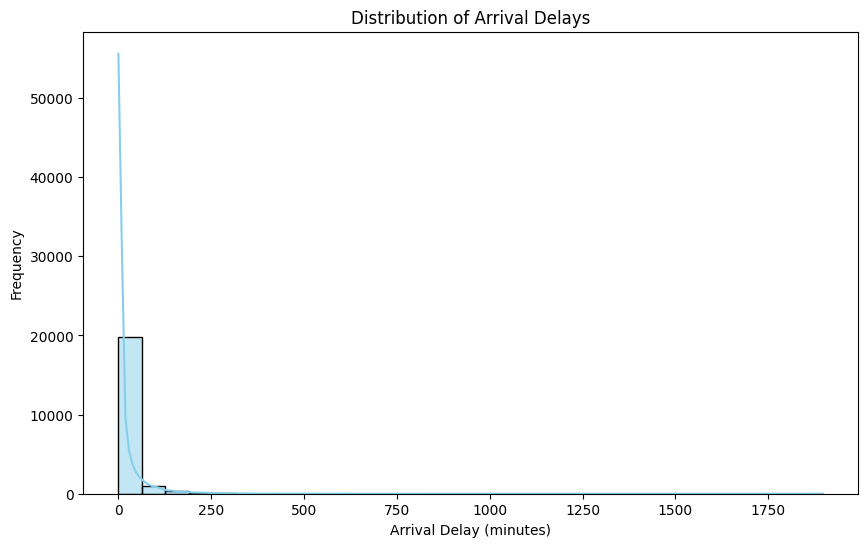

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(df['label2'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

# Remove uneccesary columns

In [52]:
df = df[features+['label1','label2']]

# Lets Finalize Features
## Convert Strings to Numerical, with Label Encoding

In [53]:
df.dtypes

month                        int32
day                          int32
day_of_week                  int32
unique_carrier_id           object
flight_number                int64
origin_airport              object
destination_airport         object
expected_departure_time      int32
expected_arrival_time        int32
awnd_x                     float64
prcp_x                     float64
snow_x                       int64
tavg_x                     float64
wdf2_x                     float64
awnd_y                     float64
prcp_y                     float64
snow_y                       int64
tavg_y                     float64
wdf2_y                     float64
label1                       int64
label2                       int64
dtype: object

In [54]:
label_encoder = LabelEncoder()

label_encoder_mappings = {}

categorical_columns = ['unique_carrier_id', 'origin_airport', 'destination_airport']

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
    label_encoder_mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for column, mapping in label_encoder_mappings.items():
    print(f"Mapping for {column}:", mapping)

joblib.dump(label_encoder_mappings, 'label_encoder_mappings.joblib')

Mapping for unique_carrier_id: {'9E': 0, 'AA': 1, 'AS': 2, 'B6': 3, 'DL': 4, 'F9': 5, 'G4': 6, 'HA': 7, 'MQ': 8, 'NK': 9, 'OH': 10, 'OO': 11, 'QX': 12, 'UA': 13, 'WN': 14, 'YV': 15, 'YX': 16}
Mapping for origin_airport: {'ABE': 0, 'ABI': 1, 'ABQ': 2, 'ABR': 3, 'ABY': 4, 'ACK': 5, 'ACT': 6, 'ACV': 7, 'ACY': 8, 'ADQ': 9, 'AEX': 10, 'AGS': 11, 'AKN': 12, 'ALB': 13, 'AMA': 14, 'ANC': 15, 'APN': 16, 'ASE': 17, 'ATL': 18, 'ATW': 19, 'AUS': 20, 'AVL': 21, 'AVP': 22, 'AZA': 23, 'AZO': 24, 'BDL': 25, 'BET': 26, 'BGR': 27, 'BHM': 28, 'BIH': 29, 'BIL': 30, 'BIS': 31, 'BJI': 32, 'BLI': 33, 'BLV': 34, 'BMI': 35, 'BNA': 36, 'BOI': 37, 'BOS': 38, 'BQK': 39, 'BRD': 40, 'BRO': 41, 'BTM': 42, 'BTR': 43, 'BTV': 44, 'BUF': 45, 'BUR': 46, 'BWI': 47, 'BZN': 48, 'CAE': 49, 'CAK': 50, 'CDV': 51, 'CHA': 52, 'CHO': 53, 'CHS': 54, 'CID': 55, 'CKB': 56, 'CLE': 57, 'CLT': 58, 'CMH': 59, 'CMI': 60, 'CMX': 61, 'CNY': 62, 'COS': 63, 'COU': 64, 'CRP': 65, 'CRW': 66, 'CSG': 67, 'CVG': 68, 'CWA': 69, 'DAB': 70, 'DAL': 7

['label_encoder_mappings.joblib']

# Look at Data Correlation

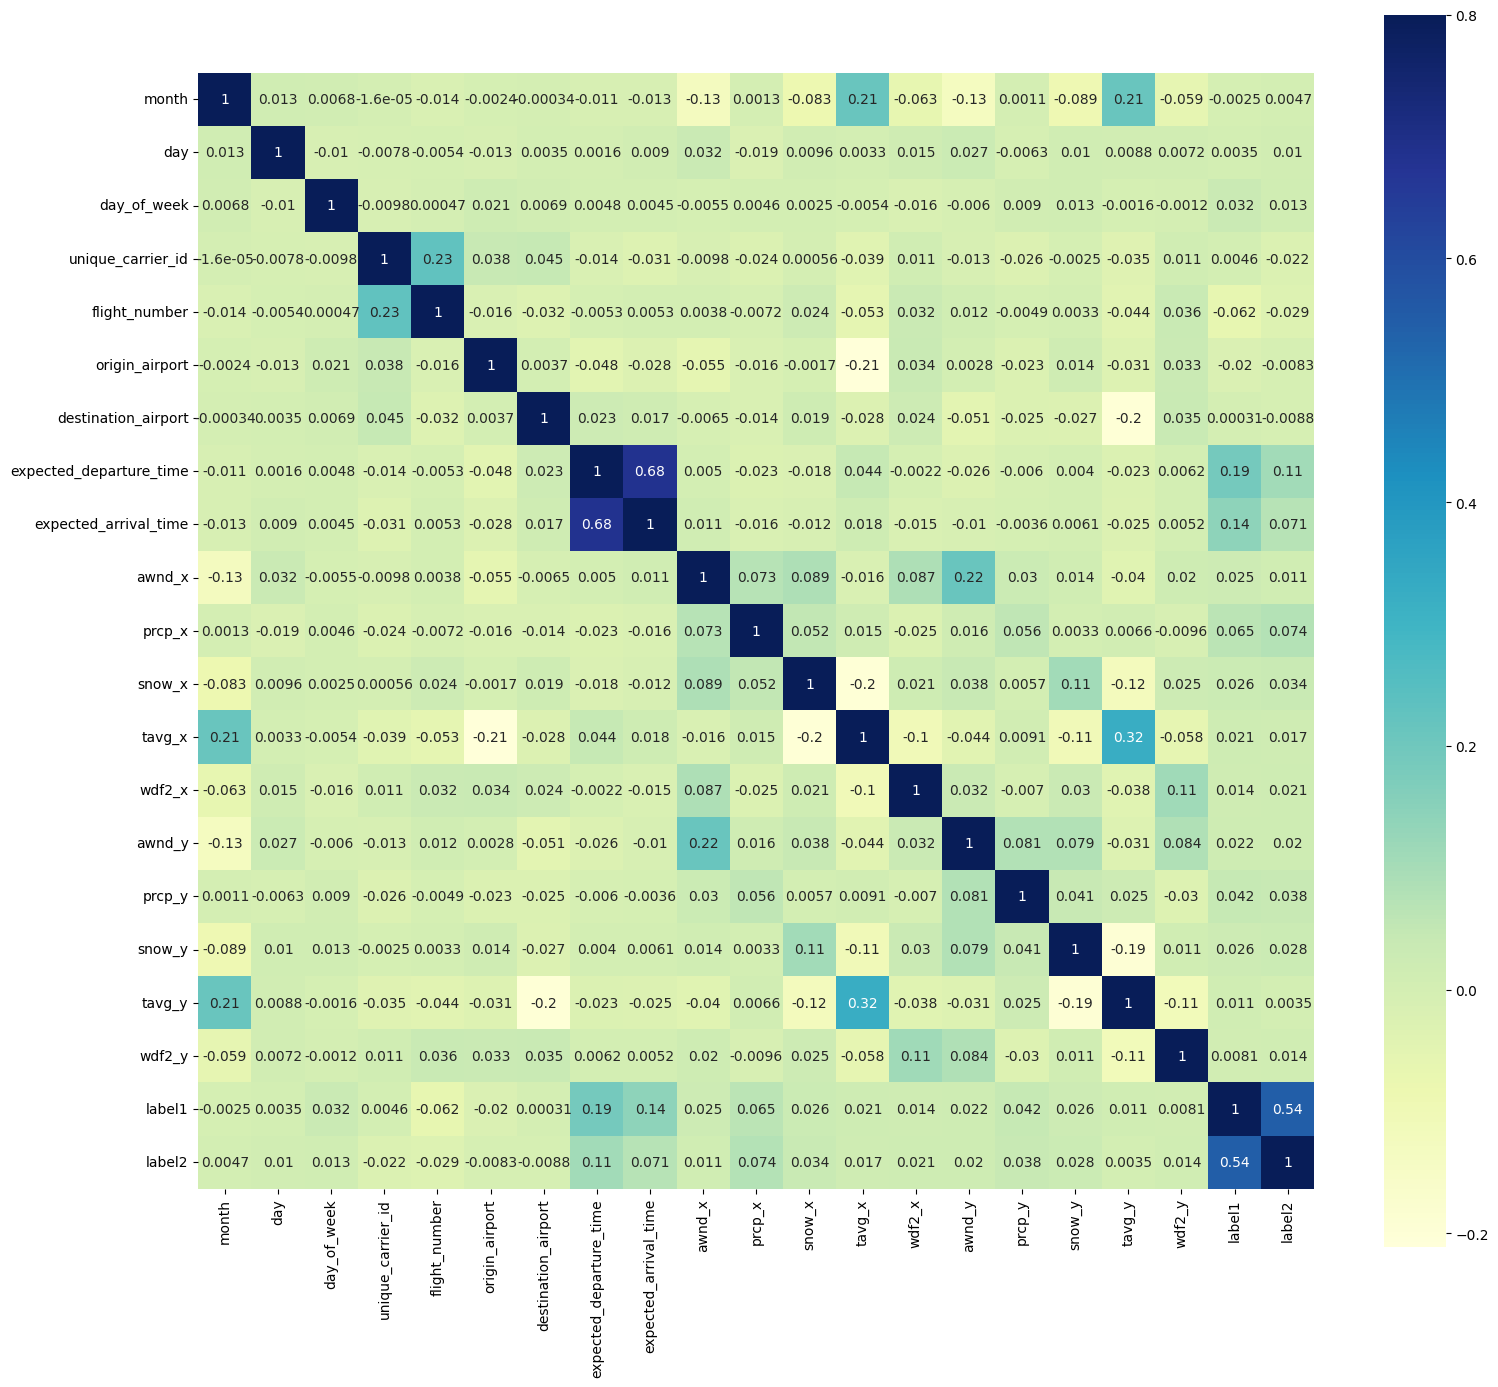

In [55]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(corrmat, vmax=.8, square=True,  cmap="YlGnBu",annot=True);
plt.show()

In [56]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [57]:
corr_features = correlation(df, 0.9)
corr_features

set()

Let's drop these columns since they're highly correlated

In [58]:
# df.drop(corr_features,inplace=True,axis=1)
# df.head()

Now, let's look at column-wise correlation between features using Pearson correlation.


In [59]:
pearson = df.corr(method='pearson')
s = pearson.abs().unstack()
so = s.sort_values(kind="quicksort", ascending=False)
num_columns = len(pearson.columns)
print(so[num_columns:num_columns+20])

expected_arrival_time    expected_departure_time    0.684578
expected_departure_time  expected_arrival_time      0.684578
label2                   label1                     0.544745
label1                   label2                     0.544745
tavg_y                   tavg_x                     0.322984
tavg_x                   tavg_y                     0.322984
flight_number            unique_carrier_id          0.230310
unique_carrier_id        flight_number              0.230310
awnd_y                   awnd_x                     0.215015
awnd_x                   awnd_y                     0.215015
tavg_x                   month                      0.214280
month                    tavg_x                     0.214280
                         tavg_y                     0.212652
tavg_y                   month                      0.212652
tavg_x                   origin_airport             0.210826
origin_airport           tavg_x                     0.210826
tavg_x                  

And now we'll look at the most highly correlated columns to our delay in minutes.

In [60]:
print(so.loc['label2'])

label2                     1.000000
label1                     0.544745
expected_departure_time    0.105870
prcp_x                     0.073611
expected_arrival_time      0.071286
prcp_y                     0.038392
snow_x                     0.034461
flight_number              0.029455
snow_y                     0.028083
unique_carrier_id          0.022319
wdf2_x                     0.020858
awnd_y                     0.020338
tavg_x                     0.017231
wdf2_y                     0.014185
day_of_week                0.013392
awnd_x                     0.011310
day                        0.009952
destination_airport        0.008797
origin_airport             0.008302
month                      0.004653
tavg_y                     0.003500
dtype: float64


Let's do the same thing with Spearman correlation, just to double check.



In [61]:
spearman = df.corr(method="spearman")
s = spearman.abs().unstack()
ss = s.sort_values(kind="quicksort", ascending=False)
num_columns_spearman = len(spearman.columns)
print(ss[num_columns_spearman:num_columns_spearman+20])

label1                   label2                     0.813852
label2                   label1                     0.813852
expected_arrival_time    expected_departure_time    0.781939
expected_departure_time  expected_arrival_time      0.781939
tavg_y                   tavg_x                     0.473241
tavg_x                   tavg_y                     0.473241
tavg_y                   month                      0.313445
month                    tavg_y                     0.313445
                         tavg_x                     0.309072
tavg_x                   month                      0.309072
snow_x                   prcp_x                     0.225356
prcp_x                   snow_x                     0.225356
label2                   expected_departure_time    0.214985
expected_departure_time  label2                     0.214985
snow_x                   tavg_x                     0.209277
tavg_x                   snow_x                     0.209277
prcp_y                  

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21319 entries, 0 to 21318
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   month                    21319 non-null  int32  
 1   day                      21319 non-null  int32  
 2   day_of_week              21319 non-null  int32  
 3   unique_carrier_id        21319 non-null  int64  
 4   flight_number            21319 non-null  int64  
 5   origin_airport           21319 non-null  int64  
 6   destination_airport      21319 non-null  int64  
 7   expected_departure_time  21319 non-null  int32  
 8   expected_arrival_time    21319 non-null  int32  
 9   awnd_x                   21319 non-null  float64
 10  prcp_x                   21319 non-null  float64
 11  snow_x                   21319 non-null  int64  
 12  tavg_x                   21319 non-null  float64
 13  wdf2_x                   21319 non-null  float64
 14  awnd_y                

# PCA

In [63]:
df_orig = df
df_orig.head()

,month,day,day_of_week,unique_carrier_id,flight_number,origin_airport,destination_airport,expected_departure_time,expected_arrival_time,awnd_x,...,snow_x,tavg_x,wdf2_x,awnd_y,prcp_y,snow_y,tavg_y,wdf2_y,label1,label2
0,5,20,5,14,1623,18,167,525,660,5.37,...,0,70.0,340.0,8.28,1.26,0,60.0,180.0,1,111
1,5,21,6,7,29,256,203,605,800,7.38,...,0,59.0,30.0,14.76,0.00,0,80.0,40.0,1,89
2,5,20,5,3,777,38,158,1070,1258,9.40,...,0,59.0,180.0,6.71,0.00,0,83.0,220.0,0,0
3,5,18,3,4,1864,146,149,360,510,2.91,...,0,73.0,140.0,10.51,0.00,0,52.0,170.0,1,22
4,5,2,1,4,2775,18,197,600,703,14.99,...,0,60.0,300.0,15.66,0.00,0,50.0,360.0,0,0


In [64]:
bucketized_delay = ['' for i in range(len(df['label2']))]
print(df['label2'][99])
for i in range(len(df['label2'])):
  try:
    if df['label2'][i] >= 0 and df['label2'][i] < 14:
      bucketized_delay[i] = 0
    elif df['label2'][i] >= 15 and df['label2'][i] < 30:
      bucketized_delay[i] = 1
    elif df['label2'][i] >= 30 and df['label2'][i] < 60:
      bucketized_delay[i] = 2
    elif df['label2'][i] >= 60 and df['label2'][i] < 90:
      bucketized_delay[i] = 3
    elif df['label2'][i] >= 90 and df['label2'][i] < 120:
      bucketized_delay[i] = 4
    elif df['label2'][i] >= 120:
      bucketized_delay[i] = 5
  except:
    continue
df['bucketized_delay'] = bucketized_delay
df

0


,month,day,day_of_week,unique_carrier_id,flight_number,origin_airport,destination_airport,expected_departure_time,expected_arrival_time,awnd_x,...,tavg_x,wdf2_x,awnd_y,prcp_y,snow_y,tavg_y,wdf2_y,label1,label2,bucketized_delay
0,5,20,5,14,1623,18,167,525,660,5.37,...,70.0,340.0,8.28,1.26,0,60.000000,180.0,1,111,4
1,5,21,6,7,29,256,203,605,800,7.38,...,59.0,30.0,14.76,0.00,0,80.000000,40.0,1,89,3
2,5,20,5,3,777,38,158,1070,1258,9.40,...,59.0,180.0,6.71,0.00,0,83.000000,220.0,0,0,0
3,5,18,3,4,1864,146,149,360,510,2.91,...,73.0,140.0,10.51,0.00,0,52.000000,170.0,1,22,1
4,5,2,1,4,2775,18,197,600,703,14.99,...,60.0,300.0,15.66,0.00,0,50.000000,360.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21314,11,5,5,14,1633,36,47,995,1160,12.75,...,67.0,170.0,6.04,0.00,0,68.000000,140.0,0,4,0
21315,11,1,1,8,4120,78,118,1020,1074,5.14,...,66.0,160.0,6.49,0.00,0,57.838706,140.0,0,0,0
21316,11,12,5,4,932,147,18,779,928,14.54,...,67.0,180.0,10.74,0.00,0,63.000000,350.0,0,0,0
21317,11,25,4,16,3652,93,209,960,1048,12.30,...,48.0,320.0,3.80,1.04,0,52.000000,360.0,0,0,0


In [65]:
df['bucketized_delay'].value_counts()

bucketized_delay
0    16437
1     1632
2     1443
3      664
5      622
4      372
       149
Name: count, dtype: int64

In [27]:
df['label2'].value_counts()

label2
0       12824
1         485
2         389
3         362
4         321
        ...  
1166        1
548         1
389         1
303         1
392         1
Name: count, Length: 345, dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21319 entries, 0 to 21318
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   month                    21319 non-null  int32  
 1   day                      21319 non-null  int32  
 2   day_of_week              21319 non-null  int32  
 3   unique_carrier_id        21319 non-null  int64  
 4   flight_number            21319 non-null  int64  
 5   origin_airport           21319 non-null  int64  
 6   destination_airport      21319 non-null  int64  
 7   expected_departure_time  21319 non-null  int32  
 8   expected_arrival_time    21319 non-null  int32  
 9   awnd_x                   21319 non-null  float64
 10  prcp_x                   21319 non-null  float64
 11  snow_x                   21319 non-null  int64  
 12  tavg_x                   21319 non-null  float64
 13  wdf2_x                   21319 non-null  float64
 14  lat_x                 

In [81]:
df_orig = df.drop(['bucketized_delay'], axis=1)
print(df_orig.columns)

pca = PCA(n_components=2)
pc = pca.fit_transform(df_orig)
pdf = pd.DataFrame(data = pc
             , columns = ['pc1', 'pc2'])
finalpdf = pd.concat([pdf, df[['bucketized_delay']]], axis = 1)
finalpdf

Index(['month', 'day', 'day_of_week', 'unique_carrier_id', 'flight_number',
       'origin_airport', 'destination_airport', 'expected_departure_time',
       'expected_arrival_time', 'awnd_x', 'prcp_x', 'snow_x', 'snwd_x',
       'tavg_x', 'wdf2_x', 'lat_x', 'long_x', 'awnd_y', 'prcp_y', 'snow_y',
       'snwd_y', 'tavg_y', 'wdf2_y', 'lat_y', 'long_y', 'label1', 'label2'],
      dtype='object')


,pc1,pc2,bucketized_delay
0,-723.494193,370.872612,4
1,-2318.771390,215.387965,3
2,-1569.584439,-436.973549,0
3,-482.907187,594.780519,1
4,428.815578,289.352618,0
...,...,...,...
21314,-713.600240,-313.554836,0
21315,1773.045876,-267.117284,0
21316,-1414.171808,4.124669,0
21317,1305.836210,-207.571719,0


Now, what I'm doig is plotting a graph that makes a scatter plot of the separation between the 2 principal components we found by bucketized_delay. Essentially what we are doing is depicting how well the PCA with n=2 clusters our original data, as well as how outliers and variable our data is on the reduced dimension space.

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  186  187  188  189  190  191  192  193  194  195
  196 

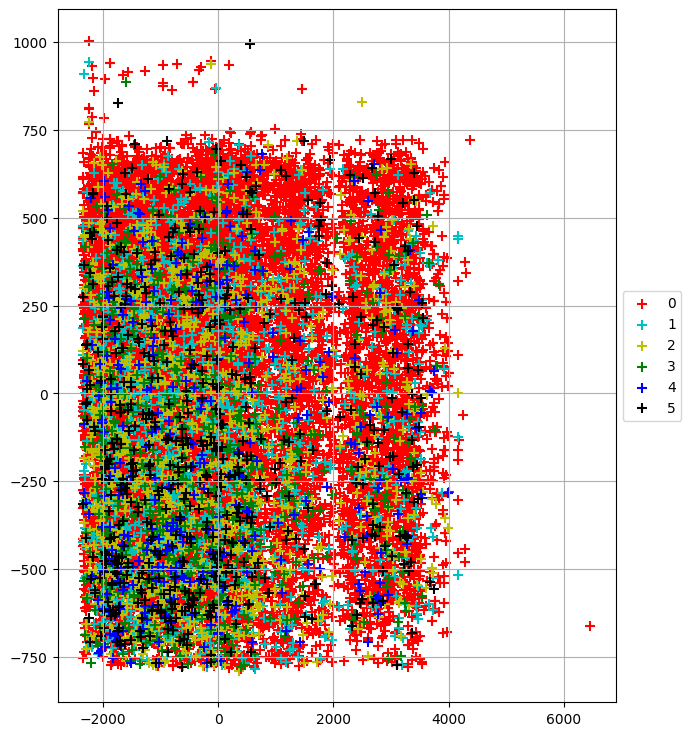

In [86]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(1,1,1)
targets = df['label2'].unique()
print(np.sort(targets))
targets = [0,1,2,3,4,5]

colors = ['r', 'c', 'y', 'g', 'b', 'k']
for target, color in zip(targets, colors):
    indices = finalpdf['bucketized_delay'] == target
    ax.scatter(finalpdf.loc[indices, 'pc1'], finalpdf.loc[indices, 'pc2'], c = color, s = 50, marker='+')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(targets, loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid()

Let's try this all again with 5 Principal components

In [87]:
df_orig2 = df.drop(['bucketized_delay'], axis=1)
print(df_orig2.columns)

pca2 = PCA(n_components=5)
pc2 = pca2.fit_transform(df_orig2)
pdf2 = pd.DataFrame(data = pc2
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
finalpdf2 = pd.concat([pdf2, df[['bucketized_delay']]], axis = 1)
finalpdf2

Index(['month', 'day', 'day_of_week', 'unique_carrier_id', 'flight_number',
       'origin_airport', 'destination_airport', 'expected_departure_time',
       'expected_arrival_time', 'awnd_x', 'prcp_x', 'snow_x', 'snwd_x',
       'tavg_x', 'wdf2_x', 'lat_x', 'long_x', 'awnd_y', 'prcp_y', 'snow_y',
       'snwd_y', 'tavg_y', 'wdf2_y', 'lat_y', 'long_y', 'label1', 'label2'],
      dtype='object')


,pc1,pc2,pc3,pc4,pc5,bucketized_delay
0,-723.494193,370.872612,-37.395704,-83.747502,110.749698,4
1,-2318.771390,215.387965,-84.613156,207.248539,-2.062484,3
2,-1569.584439,-436.973549,-49.240819,1.466775,-25.832028,0
3,-482.907187,594.780519,-62.544064,59.717497,-20.457367,1
4,428.815578,289.352618,-11.706914,-175.809880,-48.251319,0
...,...,...,...,...,...,...
21314,-713.600240,-313.554836,-37.153219,74.202315,27.671697,0
21315,1773.045876,-267.117284,42.538271,80.267353,18.202586,0
21316,-1414.171808,4.124669,-40.352472,-85.346988,-117.784121,0
21317,1305.836210,-207.571719,18.382114,-195.038786,-33.084644,0


In this case, we can look at pair-wise scatter plots or 3 in a 3D space.

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  186  187  188  189  190  191  192  193  194  195
  196 

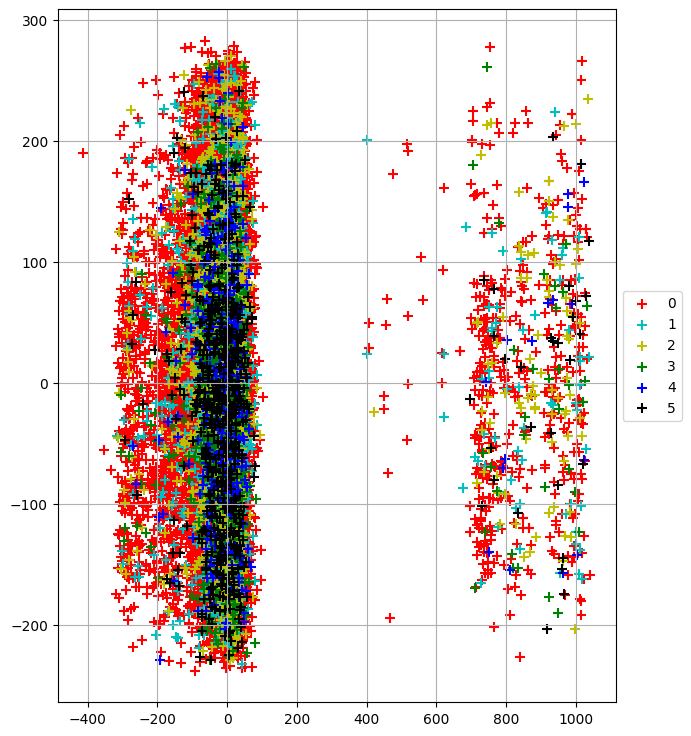

In [88]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(1,1,1)
targets = df['label2'].unique()
print(np.sort(targets))
targets = [0,1,2,3,4,5]

colors = ['r', 'c', 'y', 'g', 'b', 'k']
for target, color in zip(targets, colors):
    indices = finalpdf2['bucketized_delay'] == target
    ax.scatter(finalpdf2.loc[indices, 'pc3'], finalpdf2.loc[indices, 'pc4'], c = color, s = 50, marker='+')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(targets, loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid()

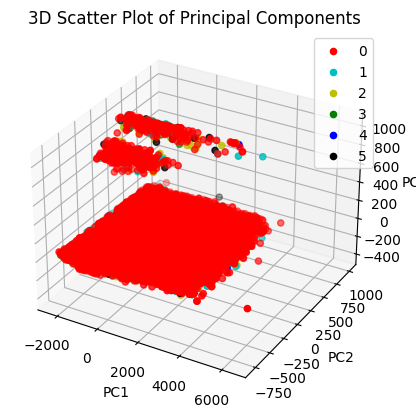

In [89]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


targets = [0,1,2,3,4,5]
colors = ['r', 'c', 'y', 'g', 'b', 'k']
for target, color in zip(targets, colors):
    indices = finalpdf2['bucketized_delay'] == target
    ax.scatter(finalpdf2.loc[indices, 'pc1'], finalpdf2.loc[indices, 'pc2'], finalpdf2.loc[indices, 'pc3'], c=color, marker='o', label=target)

# Set labels for each axis
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Set a title for the plot
ax.set_title('3D Scatter Plot of Principal Components')

# Display a legend
ax.legend()

# Show the plot
plt.show()

# Stage 1
## Predict if a delay occurs

Split data into features (X) and target variable (y)

In [66]:
df_sample = df

In [67]:
X = df_sample[features]
y = df_sample['label1']

## Split data into training and testing sets

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# X_train, y_train = oversampler.fit_resample(X_train, y_train)

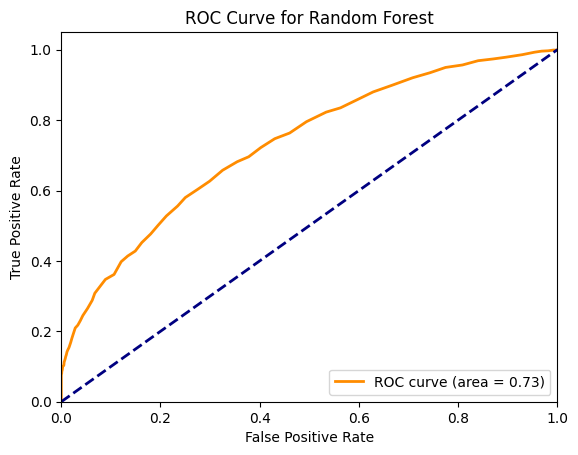

Classifier: Random Forest
AUC: 0.73
Precision: 0.75
Recall: 0.15
Accuracy: 0.79



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


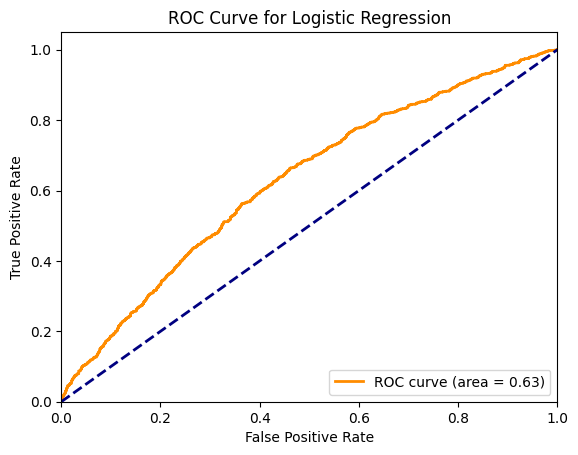

Classifier: Logistic Regression
AUC: 0.63
Precision: 0.40
Recall: 0.00
Accuracy: 0.77



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


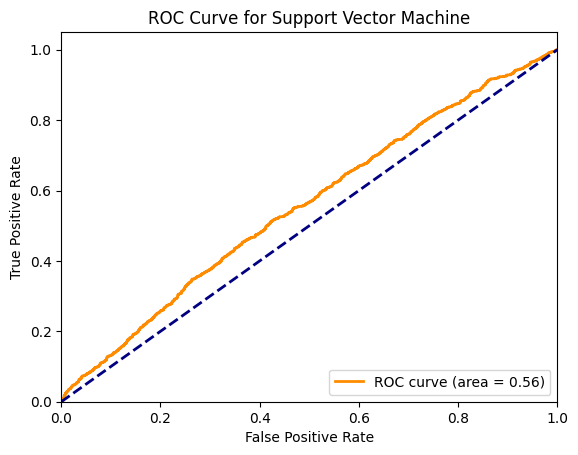

Classifier: Support Vector Machine
AUC: 0.56
Precision: 0.00
Recall: 0.00
Accuracy: 0.77



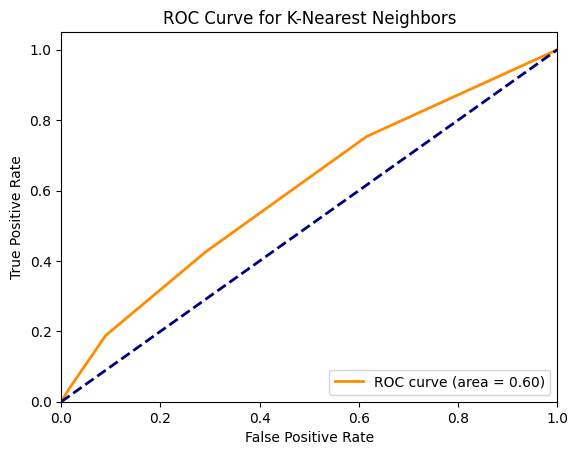

Classifier: K-Nearest Neighbors
AUC: 0.60
Precision: 0.39
Recall: 0.19
Accuracy: 0.74



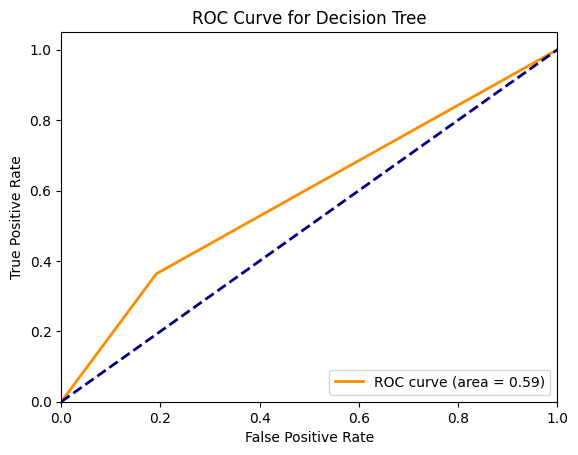

Classifier: Decision Tree
AUC: 0.59
Precision: 0.37
Recall: 0.36
Accuracy: 0.70



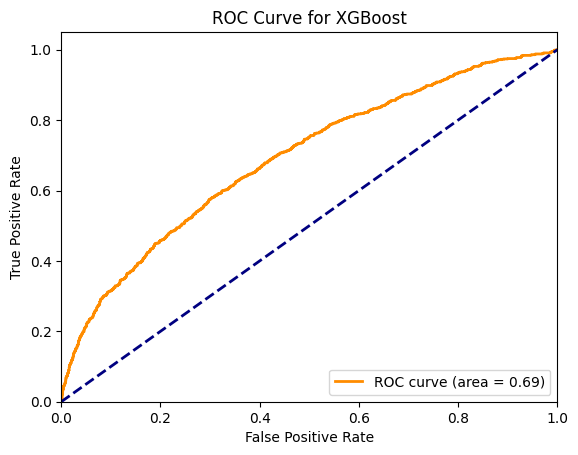

Classifier: XGBoost
AUC: 0.69
Precision: 0.57
Recall: 0.21
Accuracy: 0.78



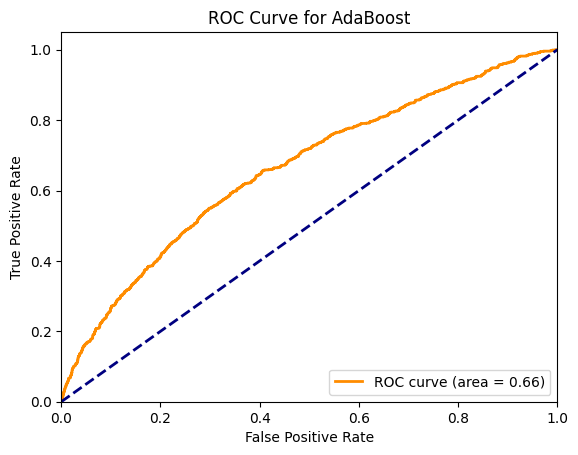

Classifier: AdaBoost
AUC: 0.66
Precision: 0.60
Recall: 0.05
Accuracy: 0.77



In [38]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_prob = classifier.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_prob)
    
    y_pred = (y_prob >= 0.5).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {}'.format(name))
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"Classifier: {name}")
    print(f"AUC: {auc_score:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Accuracy: {accuracy:.2f}\n")

# Fine Tuning Stage 1 Model

## Start with Random Search

In [39]:
param_dist = {
    'n_estimators': randint(10, 500),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Best Parameters from Random Search:")
print(random_search.best_params_)
print("\n")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters from Random Search:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 47}




## Grid Search Based on Random Search

In [40]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [12,17],
    'min_samples_split': [6, 10],
    'min_samples_leaf': [6, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:")
print(grid_search.best_params_)


Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] END bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, criterion=gini, max_depth=12, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=200; total time=   7.8s
[CV] END bootstrap=True,

## Best Params:
{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 17,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 100}

Accuracy: 0.7795
Precision: 0.7120
Recall: 0.0896
Confusion Matrix:
[[3235   36]
 [ 904   89]]


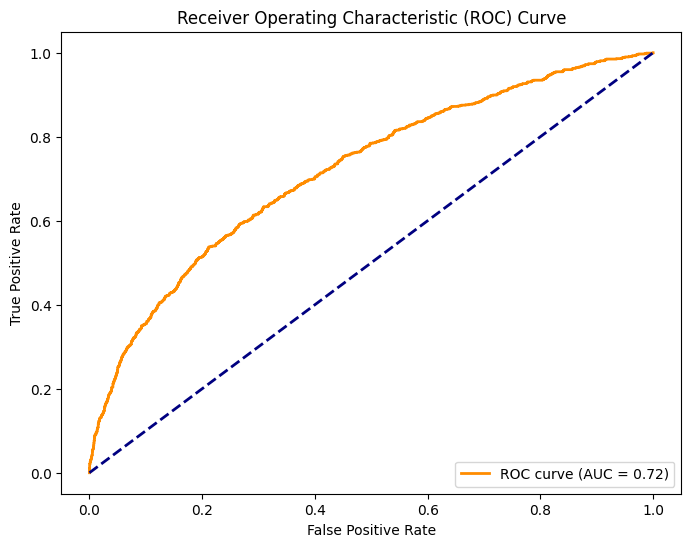

['rf_delay_binary_model.pkl']

In [69]:
rf_params = {
    'bootstrap': False,
    'criterion': 'entropy',
    'max_depth': 17,
    'max_features': 'sqrt',
    'min_samples_leaf': 6,
    'min_samples_split': 10,
    'n_estimators': 100
}

classifier = RandomForestClassifier(**rf_params)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

y_probs = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

joblib.dump(classifier,'rf_delay_binary_model.pkl', protocol=4)

# Stage 2
## Predict what buckets will be

In [70]:
df_2 = df[df['bucketized_delay'] != ''].astype(int)

In [71]:
X = df_2[features]
y = df_2['bucketized_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

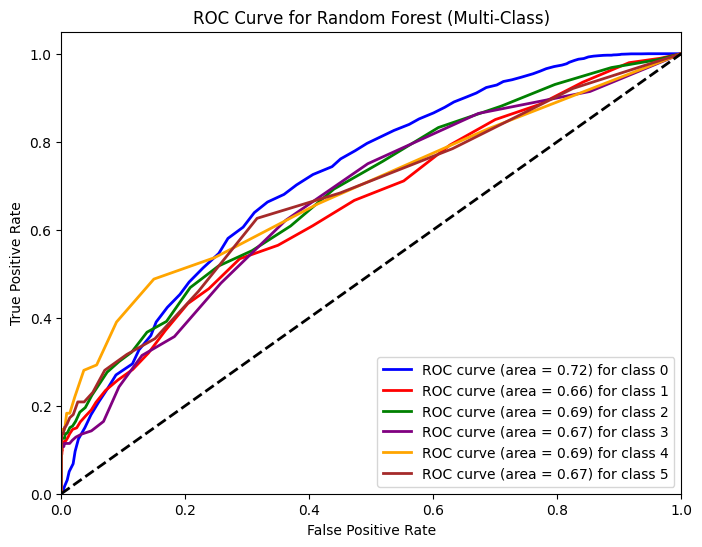

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


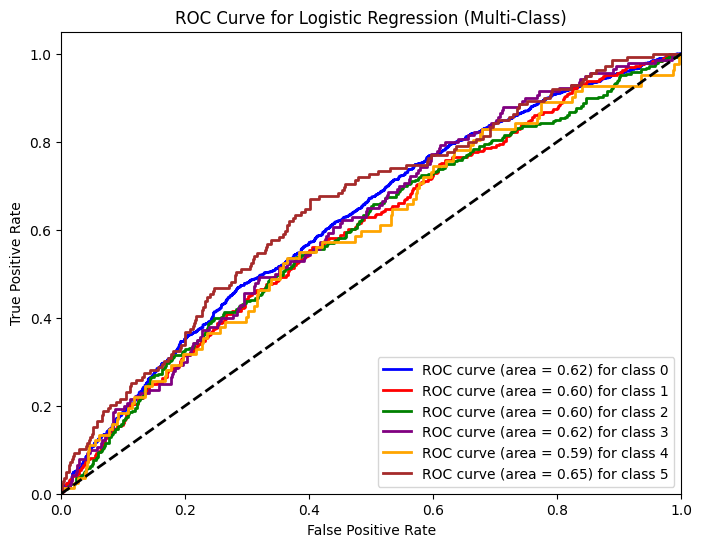

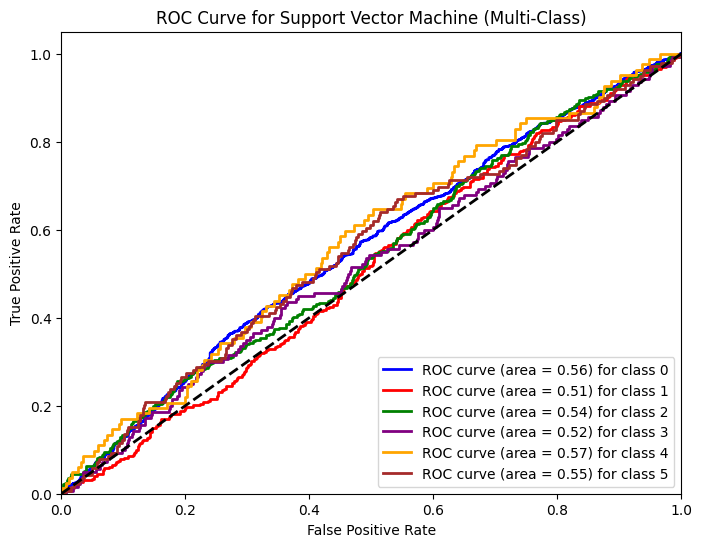

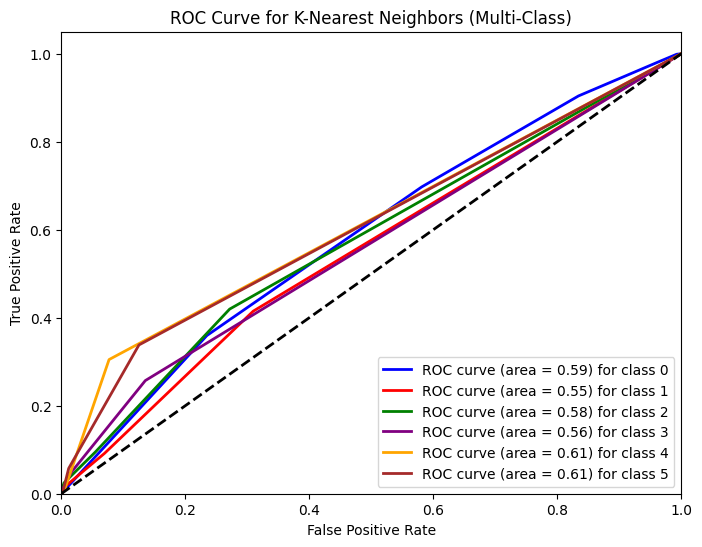

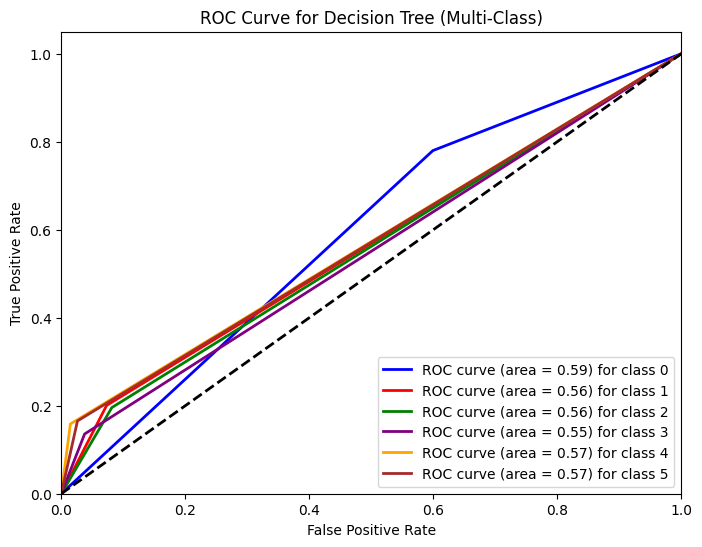

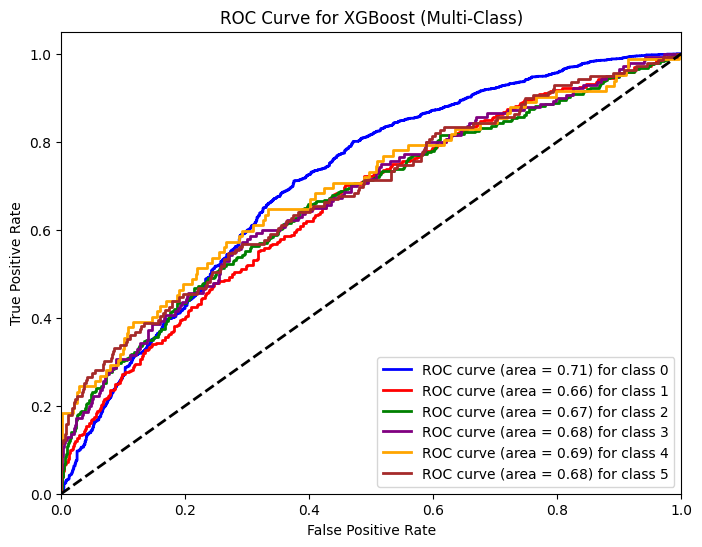

In [128]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(multi_class='ovr'),
    "Support Vector Machine": SVC(probability=True, decision_function_shape='ovr'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)

    if hasattr(classifier, 'predict_proba'):
        y_prob = classifier.predict_proba(X_test)
    else:
        y_prob = classifier.decision_function(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(np.unique(y_test))):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown'])
    for i, color in zip(range(len(np.unique(y_test))), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {} (Multi-Class)'.format(name))
    plt.legend(loc="lower right")
    plt.show()

## Random Search

In [131]:
param_dist = {
    'n_estimators': randint(10, 500),
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',  
    error_score=0,  
)

random_search.fit(X_train, y_train)

print("Best Parameters from Random Search:")
print(random_search.best_params_)
print("\n")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters from Random Search:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 122}




## Grid Search based on random search

In [132]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [15, 20],
    'min_samples_split': [5, 9],
    'min_samples_leaf': [4, 6],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    verbose=2,
    scoring='accuracy',
)

grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] END bootstrap=False, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=438; total time=   3.1s
[CV] END bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, min_samples_leaf=12, min_samples_split=19, n_estimators=197; total time=   7.6s
[CV] END bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=11, min_samples_split=7, n_estimators=16; total time=   0.3s
[CV] END bootstrap=True, criterion=gini, max_depth=6, max_features=log2, min_samples_leaf=13, min_samples_split=3, n_estimators=261; total time=   4.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=11, min_samples_split=10, n_estimators=87; total time=   4.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=19, max_features=log2, min_samples_leaf=13, min_samples_split=5, n_estimators=142; total time=   7.7s
[CV] END

## Best Params:
{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 50}

Accuracy: 0.7863
Precision: 0.8224
Recall: 0.7863
Confusion Matrix:
[[3292    0    1    0    0    0]
 [ 285    9    0    0    0    0]
 [ 266    0   20    0    0    0]
 [ 136    0    0    4    0    0]
 [  81    0    0    0    1    0]
 [ 135    1    0    0    0    3]]


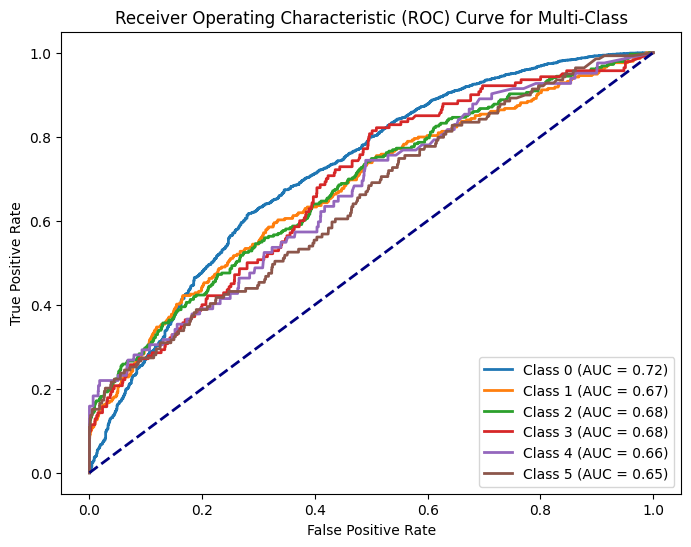

['rf_delay_bucket_model.pkl']

In [72]:
new_rf_params = {
    'bootstrap': False,
    'criterion': 'entropy',
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'n_estimators': 50
}

new_classifier = RandomForestClassifier(**new_rf_params)
new_classifier.fit(X_train, y_train)

y_pred = new_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

plt.figure(figsize=(8, 6))
for i in range(new_classifier.n_classes_):
    y_probs = new_classifier.predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_test == i, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()

joblib.dump(new_classifier, 'rf_delay_bucket_model.pkl', protocol=4)